# Title to go here

### Rajen Parekh and Prof. Yair Shenfeld

## 1. Environment Setup Instructions (macOS / Linux)

Follow the instructions below to create a virtual environment, install required packages, and register the notebook kernel.

Open a terminal and run the following commands:

```bash
cd /path to the mnk_transformer folder
chmod +x setup.sh
./setup.sh
```

This will set up a virtual enviroment to run the notebook in.


After the script finishes...
1. Reopen this notebook.
2. In the top-right corner, click the kernel selector (symbol shown below).
3. Choose the kernel named: `Python (TicTacToe)`

Then, run the cell below, and you’re ready to run and read through the notebook!

In [64]:
from play_against_gpt import play_game
import functions_for_thesis_display as f
from setup import load_from_checkpoint
model = load_from_checkpoint()

## 2. Introduction

### Introduction to GPTs
Describe what ChatGPT does, and why tic-tac-toe is an interesting toy model. Playing correct games is constructing grammatically correct sentences

### Research Questions
Mechanistic interpretability intro

What interpretability techniques do we use?

## 3. Model Representation, Architecture, and Training

This section is a more technical description of the model's architecture and training procedure.
### Tokenization of games
describe this

### Architecture
Use what I wrote last semester, with a standard description

### Loss Function and Training
Describe what the loss function is and how many training iterations, weights updated with backprop

## 4. Answering our Research Questions

### Model Success
Does the model work? This wouldn't be much of a thesis if it didn't, but test it out below! Keep in mind, the model's goal is to play a legal move, not to play *well*, so you should be able to win pretty easily, but note how it plays by the rules! Click play on the cell below and interact with the buttons to play against the model! *How* does this work? We'll get into that below...

In [65]:
play_game(model)

### Model Originality

We've seen above that the trained model can successfully play a game of tic-tac-toe. But how does it do that? Might it just be memorizing the games we showed it as it trained, and repeating them back exactly? This would be bad, especially when we think about language models! What if ChatGPT could only regurgitate exact writing that it had seen before? These models are only useful if they can generate novel games (or text!), so we test this capability.

To test the model's creativity, we train the model on 100,000 synthetically generated games of tic-tac-toe.<sup>[1]</sup> These games are created by randomly choosing a move for players until one player wins or the board is filled. After training, we have the model generate 1,000 games and measure how many of them appeared in the training set.

$$
\text{Originality Score} = 1 - \frac{\text{\# of generated games present in training dataset}}{\text{total \# of games generated}}
$$

There are 255,168 possible games of Tic-Tac-Toe, so we would expect originality scores around<sup>[2]</sup>

$$
\frac{255,\!168 - 100,\!000}{255,\!168} \approx 60.8\%
$$

Across 100 training trials (61 of which learned to play successfully before 100k iterations, which we'll call the models that "converged" later on), the mean originality score was 58.1%. So, the model is able to generate unseen game sequences at approximately the rate we'd expect.<sup>[3]</sup> It is not memorizing, but instead seems to be learning the rules of the game and generating games it has never seen before! We'll explore how it does that in the following section...

<p><sup>[1]</sup> <small><em>The model architecture is detailed in the appendix. These models were trained with 1 transformer layer, 1 attention head, and a 12-dimensional embedding.</em></small></p>

<p><sup>[2]</sup> <small><em>We would actually expect an originality score slightly higher than 60.8%, because the synthetic games are randomly generated, and can include overlapping games. A dataset with 100,000 elements is highly unlikely to have 100,000 distinct elements, but this is an expected floor for our originality score.</em></small></p>

<p><sup>[3]</sup> <small><em>This value is slightly smaller than the rate we'd expect! I think this is happening because some of the 255,168 games are more likely to occur when creating the synthetic dataset. For example, to match a short game when P1 wins quickly, only five moves need to match, but to match a long game, nine moves need to match. This means the short games are more likely to be generated synthetically (and be in our training data), and are more likely to be generated by any model that selects between moves randomly. This should drive originality scores down!</em></small></p>


### Learning the Rules of the Game
What are the rules of tic-tac-toe? Without thinking about any strategy, we can define two things a player needs to do in order to play by the rules
1. Pick a space that neither player has played in before to place their token. A space can't be occupied by multiple tokens, and if a player tries to play on top of another token, a mistake has been made!

2. Identify when the game is over and somebody has won. If the game is over and a player tries to play, or the game is not over and a player states that it is, a mistake has been made!

Let's take a closer look at the 62 training trials that learned to play successfully to see how these models might be learning the two rules stated above! Plotted below is the validation loss by iteration for each of the trials.<sup>[1]</sup> The graph is a little messy since there are so many trials shown, but run the next cell and take a look and see if you notice a trend!

<p><sup>[1]</sup> <small><em>We use categorical cross-entropy loss. The calculation of this loss is defined in the model architecture and training section.</em></small></p>

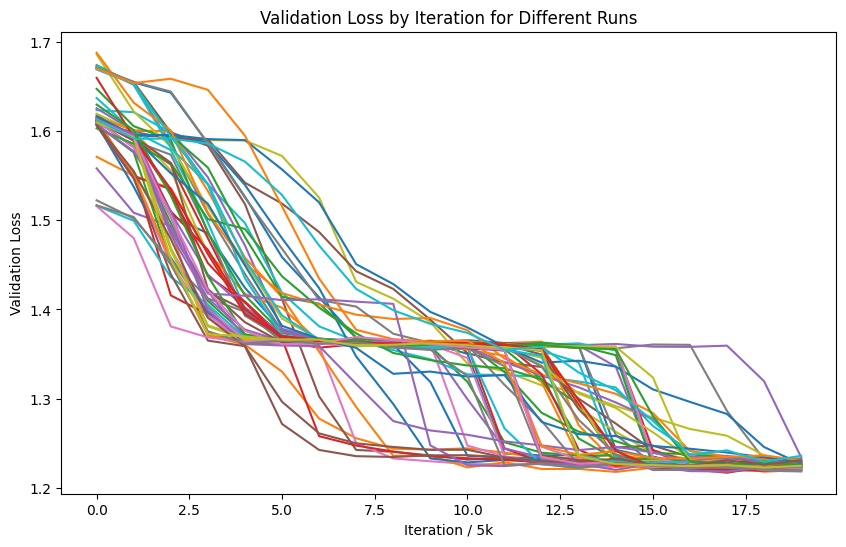

In [66]:
f.display_converging_runs()

Notice how many trials stall with a validation loss between 1.36 and 1.37? In fact, >70% of the runs that converge exhibit this stalling behavior for at least 5,000 iterations. Let's take a closer look at them and see what's going on!

We'll define two new statistics to measure how well a model understands the rules...
1. Invalid Move Rate: This measures how often the model generates a move that has been previously played in the game sequence. It is computed over all generated games (rather than all generated moves), so if a game has any invalid move, it counted towards the invalid rate. It is calculated as follows:

$$
\text{Invalid Move Rate} = \frac{\text{\# of generated games with an occupied space generated}}{\text{Total \# of generated games}}
$$

2. Correct Ending Rate: This measures how often the model predicts that the padding token will be the next token when given a game with a winner. In the training data, whenever a game ends before 9 moves (meaning a player has won before the board is full), the game sequence contains padding tokens to preserve the full sequence length. Once a model learns Rule 2, it should always predict the padding token when given a completed game to mirror this pattern in the training data.<sup>[1]</sup> It is calculated as follows:

$$
\text{Correct Ending Rate} = \frac{\text{\# of correct padding predictions after a win}}{\text{\# of generated games resulting in either player winning}}
$$

Run the cell below to randomly select one of the trials that exhibited this stalling behavior. Notice the pattern between the validation loss (rescaled to fit on the same axes), the invalid move rate, and the correct ending rate.

<p><sup>[1]</sup> <small><em>I actually made a small mistake while running tests, and only tested identifying the padding token on non-full boards (games that ended in 8 moves or less). I didn't have time to fully re-run the experiments, but from a few trials to confirm that performance was the same, I saw no difference in results. </em></small></p>

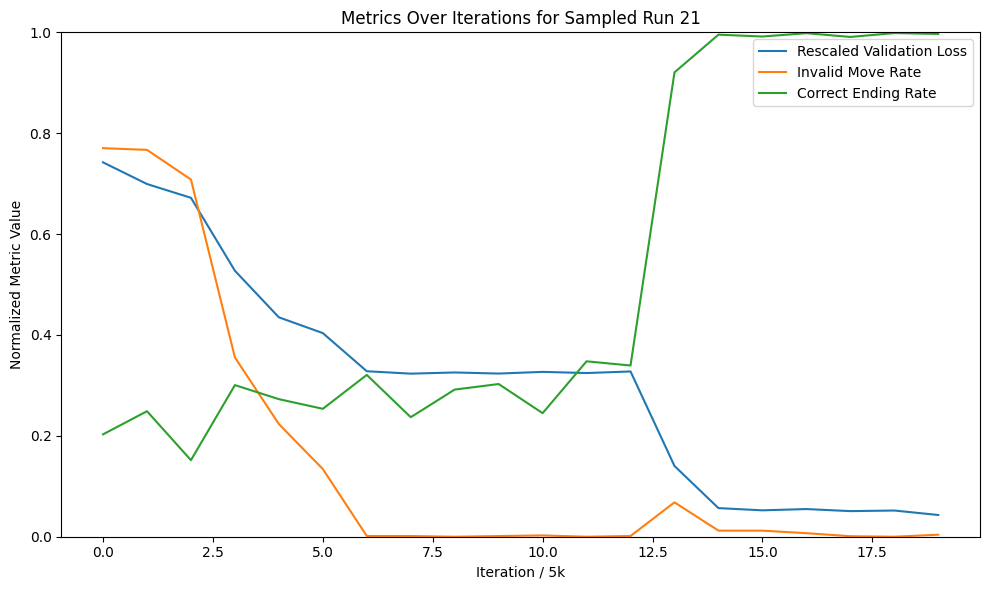

In [67]:
f.display_random_training_run()

The first thing to note is that, in all of these trials, the correct ending rate approaches 1 and the invalid move rate approaches 0 by the end of training. This means that by the end of training, the model successfully learns the rules of tic-tac-toe! It can avoid playing in occupied spaces and identifies when the game has been won.

Next, observe that the validation loss drops in two stages. During the first one, the invalid move rate drops nearly to 0, but the correct ending rate stagnates and/or fluctuates randomly, showing no improvement. Then, during the second drop, the invalid move rate increases slightly while the correct ending rate drastically increases. As training finishes, the correct ending rate gets even higher, and the invalid move rate slowly decreases back towards 0. This trend holds for all of the trials that stall with a loss between 1.36 and 1.37 for at least 5,000 iterations. Keep hitting play on the cell above to randomly select more trials and confirm this trend.

Clearly, the model seems to be learning the two rules of tic-tac-toe separately, first learning to play in unoccupied spaces and next learning to identify winners, but what is going on internally when this happens? *How* does this learning occur?

### Internal Game Representation

#### Background
A [research team from Harvard, MIT, and Northeastern](https://arxiv.org/abs/2210.13382) created a model called OthelloGPT, which was a GPT trained to generate games of Othello, another simple board game. Like our tic-tac-toe GPT, it was able to generate valid moves with very few errors. This team's central question was whether OthelloGPT had learned an internal representation of the game state without knowledge of the rules of the game.

To study this, they introduced *probes*:classifiers trained to predict the state of each space on the board (empty, Player 1, or Player 2) from the model’s internal activations after being given a sequence of moves. For each layer, they created a dataset by pairing the activations at that layer with the board state implied by the input sequence that produced them. This allowed them to evaluate what information about the board was encoded at different depths of the model.

They compared probes trained on a randomly initialized model with probes trained on a fully trained model. On the untrained model, both linear and nonlinear probes performed poorly, showing that the probes themselves were not powerful enough to extract board state from random transformations of the input sequence. On the trained model, however, a nonlinear probe was able to recover the full board state with up to 98% accuracy. This is notable because it shows that during training, OthelloGPT developed an internal representation of the game state, *even though it was never explicitly told the rules of the game*. The linear probe, by contrast, still struggled, performing only slightly better on the trained model than on the untrained model. This suggests that the learned representation was  nonlinear and not directly accessible with a simple linear decoder.

However, [Neel Nanda](https://www.neelnanda.io/mechanistic-interpretability/othello) further investigated the internal game representation of OthelloGPT. Instead of training the probe to classify a space as Player 1/Player 2/Empty, he modified the task to classify a space as "Mine"/"Opponent's"/Empty. Here's what that looks like for tic-tac-toe...

Say we have input sequence [9, 2, 5, 3, 4, 0]. Recall from the model architecture section that 9 is the start token, and the remaining tokens indicate where Player 1 and Player 2 place their alternating moves. In a Player 1/Player 2 representation, the board unsurprisingly looks as follows:

![alt text](inserted_images/probing_trial_1h.png)


Then, Nanda found that there IS a linear representation...

Our representation is learned in two stages. Does it change over time? We'll introduce our probes at the start of training (a model with random weights), when we enter stalling, when we leave stalling, and at the end of training.

Questions:
1. Does the model learn an internal representation? (are we able to predict better than the randomly initialized model?)
2. How does this internal representation change as the model trains in different stages?

#### Different Tasks to Test
Tasks 1 and 2 directly reflect the rules, Tasks 3 and 4 are a combination of the rules and test Nanda's findings
1. What spaces are occupied?
2. Has the game been won?
3. Which player has played in each space, using Player 1 vs Player 2
4. Which player has played in each spaces, using a "my" or "yours" perspective from the model

make sure to give an example of "my" vs "yours" when explaining what Nanda did

#### Different Probe Architectures
Creators of OthelloGPT didn't discuss the number of parameters of the probe, but a nonlinear MLP will have more params than the linear probe. Is the better prediction from nonlinearity or from probe size?

Describe their exact architecture in appendix

#### Results
Show a chart like the one in othello paper for each task. We have three variables, the model type, the checkpoint, and the layer. We'll have a chart for each checkpoint-task combo. Vertically, we compare model types, and horizontally, we compare BA/SA. Check markdown for what it should look like...

<!-- Task 1, Layer 1
                Checkpoint 1        Checkpoint 2        Checkpoint 3

Linear              x1/y1               x2/y2               x3/y3

Small MLP           etc.

Large MLP -->


#### Change in Number of Heads
Present results from the two-headed model. Instead of learning staggered, it learns simultaneously. Could each head be focusing on one of the rules?

## 5. Conclusion

### Summary of Findings

### Future Work


## 6. Appendix

### Parameter Allocation
Describe results we found

### Mechanistic Interpretability Lit Review
Todo

✅ Found folder: ../inserted_images
🖼️ Displaying: probing_trial_2h.png


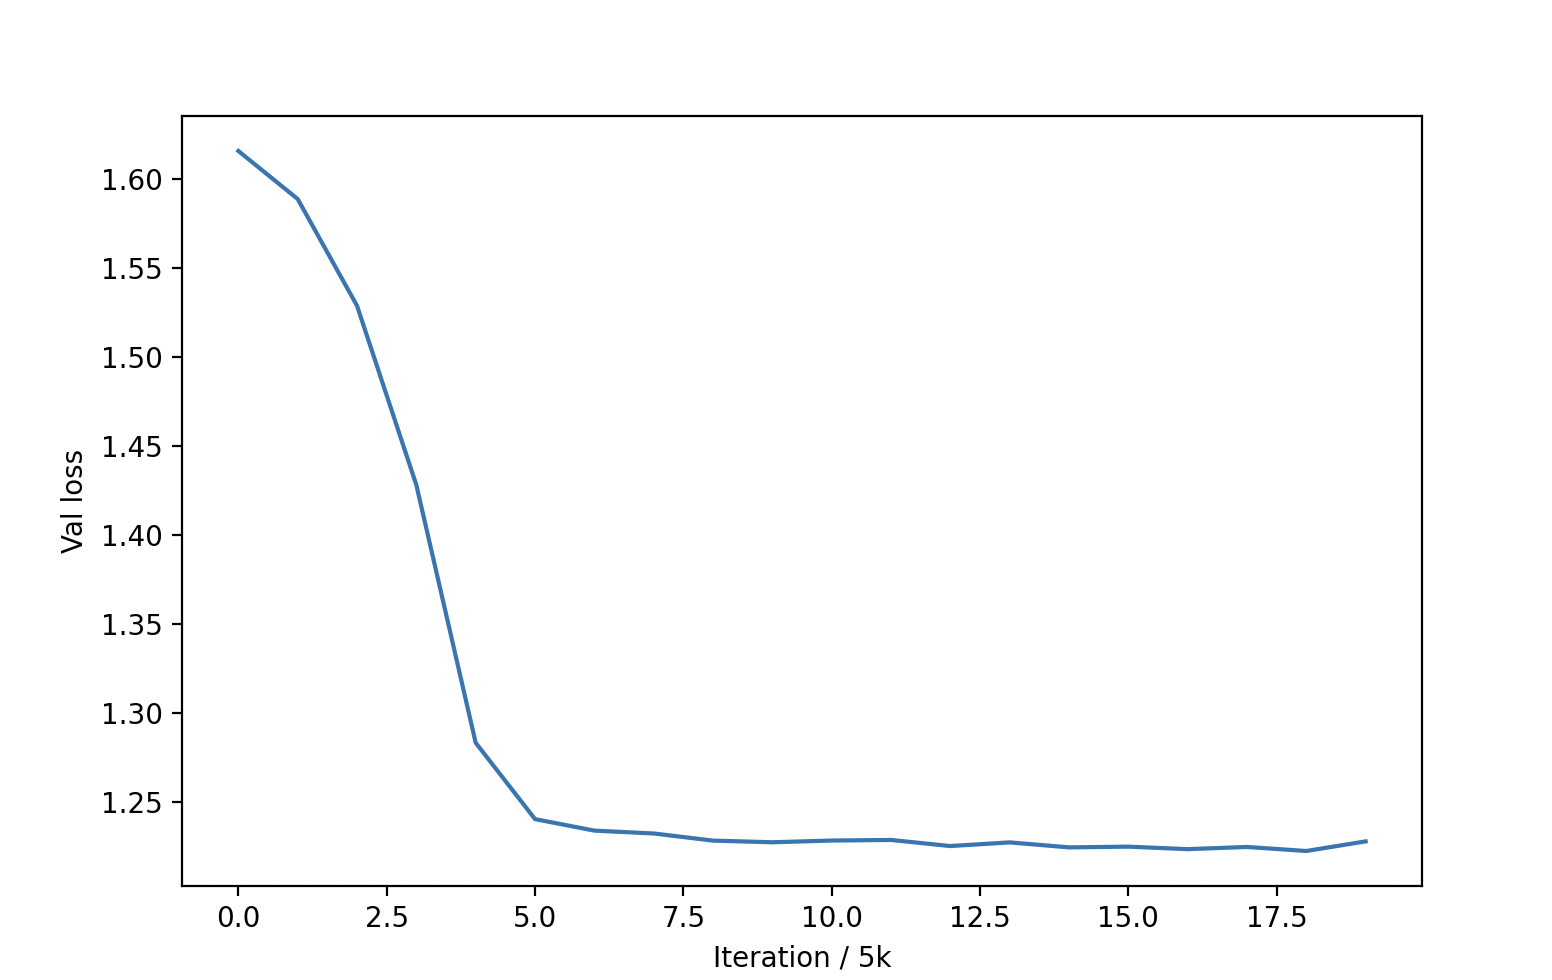

🖼️ Displaying: kernel_button.png


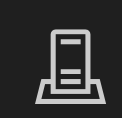

🖼️ Displaying: probing_trial_1h.png


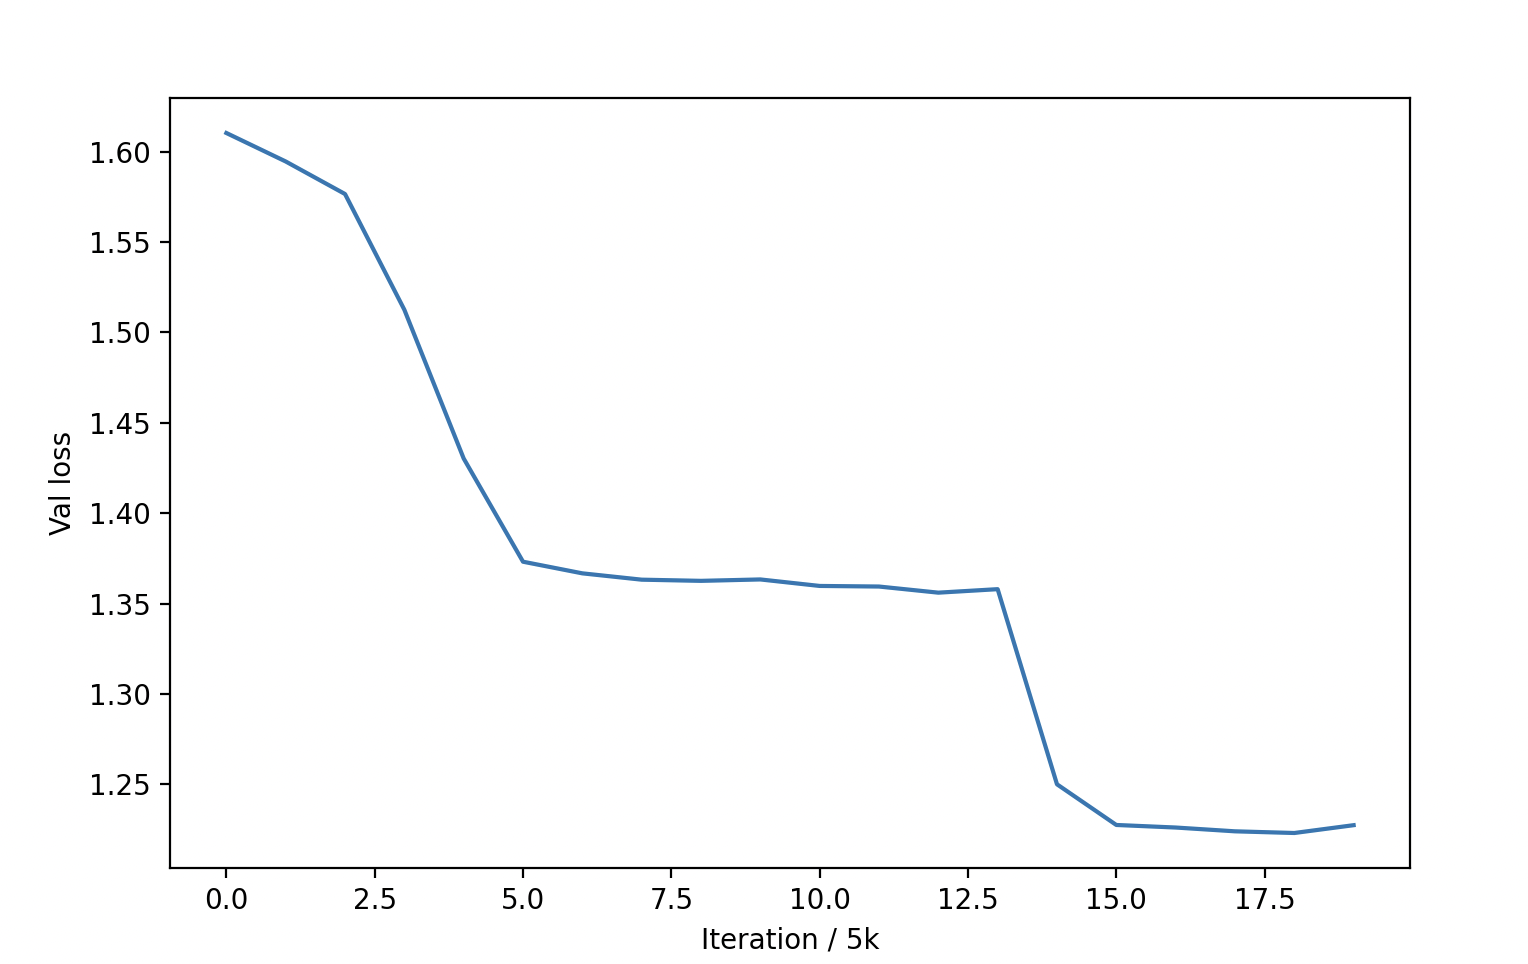

In [68]:
# How to display images, this will be removed for final version

import os
from IPython.display import Image, display

image_dir = "../inserted_images"

if os.path.exists(image_dir):
    print(f"✅ Found folder: {image_dir}")
    files = os.listdir(image_dir)
    image_files = [f for f in files if f.lower().endswith((".png", ".jpg", ".jpeg", ".gif"))]

    if not image_files:
        print("⚠️ No image files found in the folder.")
    else:
        for fname in image_files:
            fpath = os.path.join(image_dir, fname)
            print(f"🖼️ Displaying: {fname}")
            display(Image(filename=fpath))
else:
    print(f"❌ Folder not found: {image_dir}")
